# Predicting heart disease

This notebook performs heart disease classification comparing the baseline classifiers of logistic regression, k-nearest neighbors and naive bayes

# Authors

Elnaz Azizi, Charly Watts, Christian Unterrainer

# Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Data

### Load data from files

In [8]:
file_info = [
    ('heart+disease/processed.cleveland.data', False),
    ('heart+disease/processed.va.data', False),
    ('heart+disease/processed.switzerland.data', False),
    ('heart+disease/reprocessed.hungarian.data', True),  # space-separated
]

col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]

dataframes = []
for path, is_space_separated in file_info:
    if is_space_separated:
        df = pd.read_csv(path, sep=r'\s+', header=None, names=col_names, na_values='?')
    else:
        df = pd.read_csv(path, header=None, names=col_names, na_values='?')
    dataframes.append(df)

# Combine all files into one DataFrame
data = pd.concat(dataframes, ignore_index=True)

### Test split and normalize target values

In [10]:
x = data.drop('target', axis=1)
y = data['target'].astype(int).apply(lambda v: 1 if v > 0 else 0) # normalize target values 1 disease, 0 no disease

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

## Build pipeline

In [12]:
# 1. Define column types
numeric_cols     = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# 2. Define preprocessing pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
   ('cat', cat_pipe, categorical_cols)
])

# 3. Build full pipeline
logistic_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression())
])

kneighbors_pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])

naive_pipeline = Pipeline([
    ('pre', preprocessor),
    ('nav', GaussianNB())
])

# 4. Define parameter grid
logistic_param_grid = {'clf__C': [0.01, 0.1, 1, 10]}
kneighbors_param_grid = {'knn__n_neighbors': list(range(1,21))}
naive_param_grid = {}  # No parameters to search

# 5. Grid search with cross-validation
logistic_grid = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='recall', n_jobs=-1)
logistic_grid.fit(x_train, y_train)

kneighbors_grid = GridSearchCV(kneighbors_pipeline, kneighbors_param_grid, cv=5, scoring='recall', n_jobs=-1)
kneighbors_grid.fit(x_train, y_train)

naive_grid = GridSearchCV(naive_pipeline, naive_param_grid, cv=5, scoring='recall', n_jobs=-1)
naive_grid.fit(x_train, y_train);

# Experiments

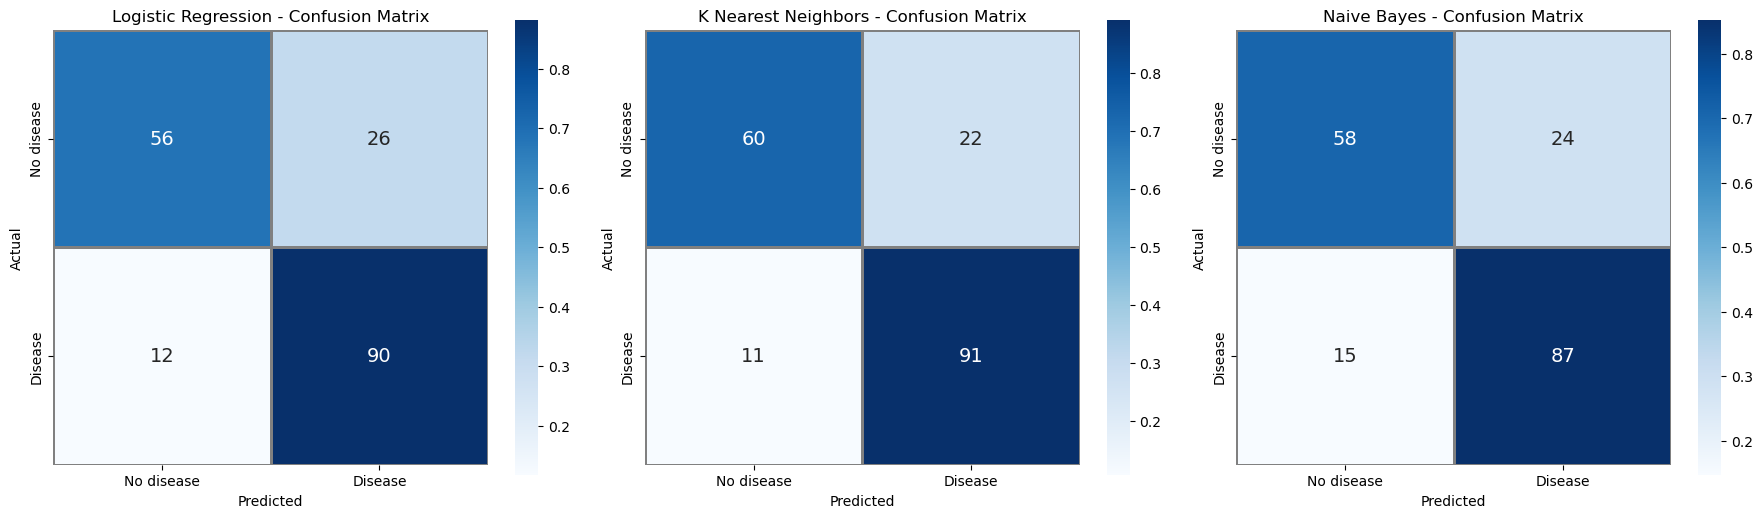

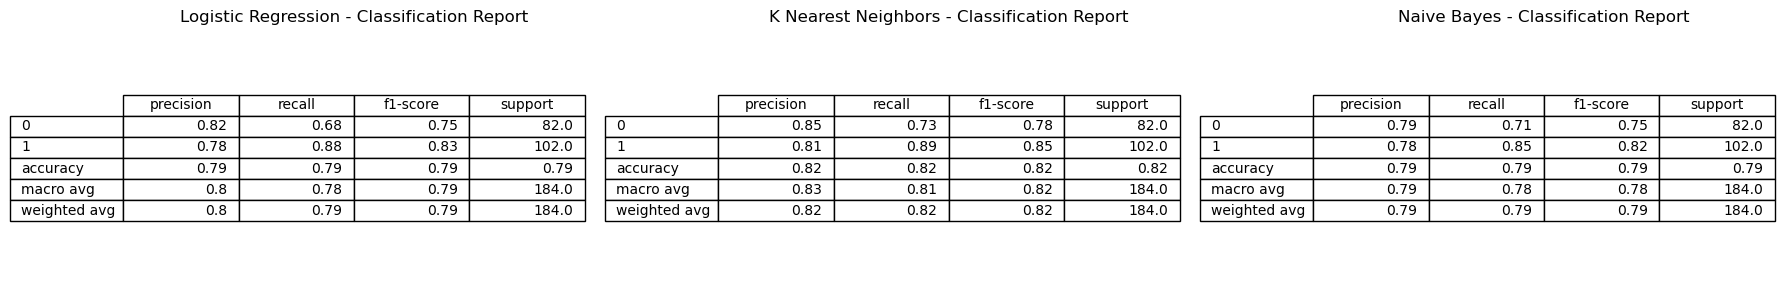

In [14]:
results = []
models = [logistic_grid.best_estimator_, kneighbors_grid.best_estimator_, naive_grid.best_estimator_]
model_names = ["Logistic Regression", "K Nearest Neighbors", "Naive Bayes"]

for model, name in zip(models, model_names):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        "name": name,
        "model": model,
        "y_pred": y_pred,
        "cm": cm,
        "report": report
    })

fig, axs = plt.subplots(1, len(results), figsize=(6 * len(results), 5))

for i, res in enumerate(results):
    cm_norm = res["cm"].astype(float) / res["cm"].sum(axis=1)[:, None]
    labels = ['No disease', 'Disease']
    sns.heatmap(
        cm_norm,
        annot=res["cm"],
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        ax=axs[i],
        annot_kws={'size': 14},
        linewidths=1,
        linecolor='gray'
    )
    axs[i].set_title(f'{res["name"]} - Confusion Matrix')
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, len(results), figsize=(6 * len(results), 3))

for i, res in enumerate(results):
    df_report = pd.DataFrame(res["report"]).T.round(2)

    axs[i].axis('off')
    axs[i].set_title(f'{res["name"]} - Classification Report', fontsize=12, pad=10)
    table = axs[i].table(
        cellText=df_report.values,
        colLabels=df_report.columns,
        rowLabels=df_report.index,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()

# Discussion

### Discussion

**Goal:**  
The primary objective of this project was to maximize **recall**, ensuring that as many patients with heart disease as possible are correctly identified. In medical diagnosis, minimizing **false negatives** is crucial, as failing to detect a condition can have serious consequences. Therefore, the model with the highest recall is considered most appropriate for this task.

---

**K-Nearest Neighbors (k-NN):**
- Among the three models tested, **k-NN achieved the highest recall**, making it the most effective at detecting patients with heart disease.
- This strong recall suggests that k-NN rarely misses true positive cases, which aligns well with our project’s goal of minimizing false negatives.
- However, this came at the cost of **lower precision**, meaning it also produced more false positives—cases where the model incorrectly predicted disease. While less dangerous than false negatives, these still have implications, such as unnecessary anxiety or additional testing.

---

**Logistic Regression:**
- This model delivered the **highest accuracy overall**, meaning it made the most correct predictions in total.
- It maintained a **good balance between precision and recall**, which is valuable in situations where both types of errors matter.
- However, its **recall was slightly lower than k-NN**, making it slightly less reliable at catching all positive cases—an important consideration for a medical screening tool.

---

**Naive Bayes:**
- **Naive Bayes performed the worst** across all main evaluation metrics (accuracy, precision, recall, and F1-score).
- Its relatively weak performance is likely due to its underlying assumption that all features are **independent of each other**, which is often not the case in real-world medical data where features like cholesterol, blood pressure, and age can be correlated.
- Despite its speed and simplicity, the model’s limitations in this context make it less suitable for deployment.

---

**Methodology:**
- All three models were tuned using **grid search combined with 5-fold cross-validation**, ensuring fair and robust optimization of hyperparameters.
- Evaluation was done consistently using the **same test set and metrics** (accuracy, precision, recall, F1-score), allowing for reliable comparisons between the models.

---

**Conclusion:**
- Based on the goal of maximizing recall, **k-NN is selected as the best baseline model**.
- Although it introduces more false positives, it significantly reduces the chance of missing true cases, which is critical in a healthcare setting.
- Going forward, k-NN will serve as a **benchmark** for comparing more advanced models, such as decision trees, ensemble methods (like Random Forest or XGBoost), or even neural networks.
- Future improvements could also involve feature engineering, handling class imbalance, or incorporating domain knowledge to enhance model performance and reliability.
